## Data

In [133]:
from notebooks.text_processing import generate_corpus_df, add_sectarian_label, convert_df_to_by_book
import pandas as pd
import numpy as np
from notebooks.utils import generate_composition_to_book
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from tqdm import tqdm

In [134]:
df = generate_corpus_df()
df = add_sectarian_label(df)

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
scroll,1001,1428.81,100
lex,10450,129.14,94
fragment,11182,127.91,100
line,52895,27.04,100
clause,125,12.85,0
cluster,101099,6.68,47
phrase,315,5.10,0
word,500995,2.81,99
sign,1430241,1.00,100


100%|██████████| 52895/52895 [00:04<00:00, 11215.82it/s]
[04-24 17:54:39] {/Users/yonatanlou/dev/QumranNLP/notebooks/text_processing.py:65} INFO - Generated 997 unique books
/Users/yonatanlou/dev/QumranNLP/notebooks/utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["book_pasuk"] = df_filtered["book"] + " " + df_filtered["pasuk"]
[04-24 17:54:39] {/Users/yonatanlou/dev/QumranNLP/notebooks/text_processing.py:67} INFO - Removed 387 books that are smaller than 100 words per book


In [135]:
null_lines = (df["text"].isna())
print(f"remove {(null_lines.sum())} null lines")
df = df[~null_lines]
df_by_book = convert_df_to_by_book(df)
composition_to_book = generate_composition_to_book()
df_by_book_by_comp =pd.merge(df_by_book, composition_to_book, on="book", how="inner")
df_by_book_by_comp

remove 16 null lines


,book,text,label,section,composition
0,11Q1,וסמכ ידו על ראש השעיר ושחט אתו ╱ במקומ אשר י...,bib,NaN,Lev
1,11Q12,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאו...,nonbib,non_sectarian_texts,Book_of_Jubilees
2,11Q19,כי נורא הוא אשר אני עושה עמכה . הנני גורש מ...,nonbib,unknown,Temple Scroll
3,11Q2,ואתן אתם לאהרן הכהן ולבניו לחק עולם מאת בני ╱ ...,bib,NaN,Lev
4,11Q20,והקריבו על המזבח לכול יום ויום פר בן...,nonbib,unknown,Temple Scroll
...,...,...,...,...,...
355,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Nah
356,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Obad
357,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Zech
358,Mur88,╱ . ואת הצפוני ארחיק מעליכם והדחתיו...,bib,NaN,Zeph


## Pre processing

In [136]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('hebrew'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [137]:
def pre_process(doc):
    doc = doc.replace("╱","")
    doc= re.sub(r"\s+", " ", doc)
    return doc

def replace_for_ot_sofit(word):
    OT_SOFIT = {"מ": "ם","נ": "ן","פ": "ף","צ": "ץ","כ": "ך"}
    last_char = word[-1]
    if last_char in OT_SOFIT.keys():
        word = word[:-1] + OT_SOFIT[last_char]
    return word


def remove_not_heb_chars(word):
    new_word = []
    removed_chars= set()
    for char in word:
        if char in allowed_characters:
            new_word.append(char)
        if char not in allowed_characters:
            removed_chars.add(char)
    return "".join(new_word), removed_chars
        
allowed_characters = "אבגדהוזחטיכלמנסעפצקרשתםןףךץ. 1234567890"

all_docs = []
for i, doc in enumerate(df_by_book['text']):
    doc = pre_process(doc)
    tmp_words_list = []
    word_replace_counter = 0
    chars_removed = set()
    for word in doc.split():
        word = replace_for_ot_sofit(word)
        new_word, char_removed = remove_not_heb_chars(word)
        chars_removed.update(char_removed)
        if word != new_word:
            word_replace_counter +=1
        tmp_words_list.append(new_word)
    if word_replace_counter:
        print(f"({i}) replaced {word_replace_counter} words in {df_by_book.iloc[i,:].book} ({word_replace_counter/len(doc.split()):.3f} from all words). chars removed: {chars_removed}" )
    doc = " ".join(tmp_words_list)
    all_docs.append(doc)

(56) replaced 1 words in 1QM (0.000 from all words). chars removed: {'־'}
(79) replaced 42 words in 3Q15 (0.049 from all words). chars removed: {'Κ', 'ׅ', 'Σ', 'Η', 'Θ', 'Τ', 'Γ', 'Ι', 'Α', 'Ν', 'Χ', '֜', 'Ε', 'ֽ', 'ׄ', 'Δ', 'Ρ'}
(201) replaced 1 words in 4Q249e (0.011 from all words). chars removed: {'֜'}
(259) replaced 4 words in 4Q317 (0.004 from all words). chars removed: {'֜'}
(260) replaced 104 words in 4Q318 (0.571 from all words). chars removed: {'ׅ', 'ׄ', '֜'}
(261) replaced 35 words in 4Q319 (0.040 from all words). chars removed: {'ׅ', 'ֽ', 'ׄ', '֜'}
(263) replaced 136 words in 4Q320 (0.260 from all words). chars removed: {'ׅ', 'ׄ', '֜'}
(279) replaced 1 words in 4Q345 (0.029 from all words). chars removed: {'֜'}
(280) replaced 3 words in 4Q348 (0.048 from all words). chars removed: {'֜'}
(283) replaced 1 words in 4Q360a (0.029 from all words). chars removed: {'֜', 'ׅ', 'ׄ'}
(411) replaced 1 words in 4Q498 (0.017 from all words). chars removed: {'֜'}
(418) replaced 1 words in

## Analysis

In [138]:
df_by_book["processed_text"] = all_docs
df_by_book

,book,text,label,section,processed_text
0,11Q1,וסמכ ידו על ראש השעיר ושחט אתו ╱ במקומ אשר י...,bib,NaN,וסמך ידו על ראש השעיר ושחט אתו במקום אשר ישחט ...
175,11Q10,תולעה . ומא אפו א . העמי לשאול תנחתון או ...,nonbib,NaN,תולעה . ומא אפו א . העמי לשאול תנחתון או כחדה ...
604,11Q11,וה כב הא ם ע דם סוכות ...,nonbib,NaN,וה כב הא ם ע דם סוכות לם ו . ה ת יך . ב את שבע...
700,11Q12,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאו...,nonbib,non_sectarian_texts,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאות ...
756,11Q13,שון מושה כיא ש . מ ...,nonbib,NaN,שון מושה כיא ש . ם על ל ואשר אמר בשנת היובל הז...
...,...,...,...,...,...
50464,Xjoshua,הלוא צויתיך חזק ואמץ אל תערץ ואל תחת ╱ כי עמך...,bib,NaN,הלוא צויתיך חזק ואמץ אל תערץ ואל תחת כי עמך יה...
50476,Xjudges,וילך יהודה אל הכנעני הישב בחברון ╱ ושם חברון ...,bib,NaN,וילך יהודה אל הכנעני הישב בחברון ושם חברון לפנ...
50499,Xq1,ויאמר יהוה אל משה ואהרן זאת חקת הפסח כל בן נכר...,bib,NaN,ויאמר יהוה אל משה ואהרן זאת חקת הפסח כל בן נכר...
50525,Xq2,את הדברים האלה דבר יהוה עם כל קהלכם בהר מתוך ה...,bib,NaN,את הדברים האלה דבר יהוה עם כל קהלכם בהר מתוך ה...


In [153]:

df_by_book["number_of_chars"] = df_by_book['processed_text'].str.len()
df_by_book["number_of_words"] = df_by_book['processed_text'].str.split().map(lambda x: len(x))
df_by_book["avg_word_length"] = df_by_book['processed_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

In [154]:
df_by_book.sort_values(by="number_of_chars",ascending=False)[["book", "number_of_chars"]].head(15)

,book,number_of_chars
7634,1Qisaa,90321
1238,11Q19,47079
36772,4Q51,46784
5888,1QHa,40596
5323,1Q8,31926
15623,4Q22,30810
48472,Mur88,28912
19710,4Q27,24047
6821,1QM,22985
2790,11Q5,22178


In [156]:
df_by_book.sort_values(by="number_of_words",ascending=False)[["book", "number_of_words"]].head(15)


,book,number_of_words
7634,1Qisaa,18179
36772,4Q51,9801
1238,11Q19,9472
5888,1QHa,8287
5323,1Q8,6720
15623,4Q22,6676
48472,Mur88,6095
19710,4Q27,4989
2790,11Q5,4527
2690,11Q5,4527


In [157]:
df_by_book.sort_values(by="avg_worg_length",ascending=False)[["book", "avg_worg_length"]].head(15)


,book,avg_worg_length
22474,4Q318,5.554945
22935,4Q321a,4.520499
33167,4Q493,4.508065
40803,4Q542,4.386525
17561,4Q249e,4.365591
22878,4Q321,4.285398
23329,4Q334,4.282609
43223,4Q581,4.196970
44236,4Q74,4.196721
20928,4Q287,4.158076


Text(0.5, 1.0, 'Average word length')

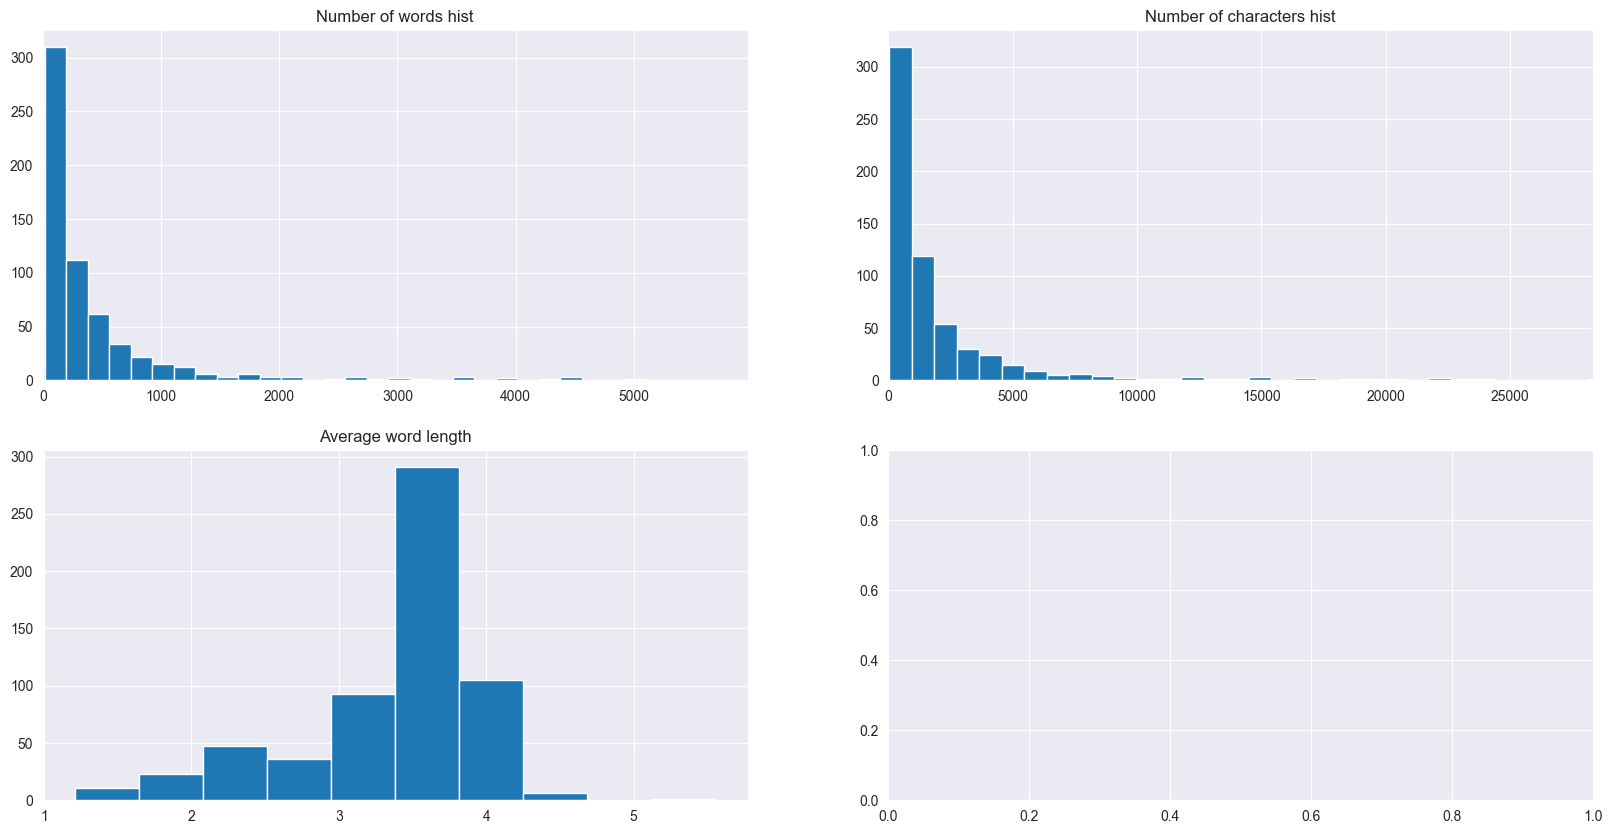

In [167]:
fig, ax = plt.subplots(2,2)
df_by_book["number_of_words"].hist(ax=ax[0,0], bins=100)
df_by_book["number_of_chars"].hist(ax=ax[0,1], bins=100)
ax[0,0].set_xlim(0,df_by_book["number_of_words"].quantile(0.99))
ax[0,1].set_xlim(0,df_by_book["number_of_chars"].quantile(0.99))
df_by_book["avg_word_length"].hist(ax=ax[1,0])
ax[0,0].set_title("Number of words hist")
ax[0,1].set_title("Number of characters hist")
ax[1,0].set_title("Average word length")


Text(0.5, 1.0, 'Top 20 stop words in corpus')

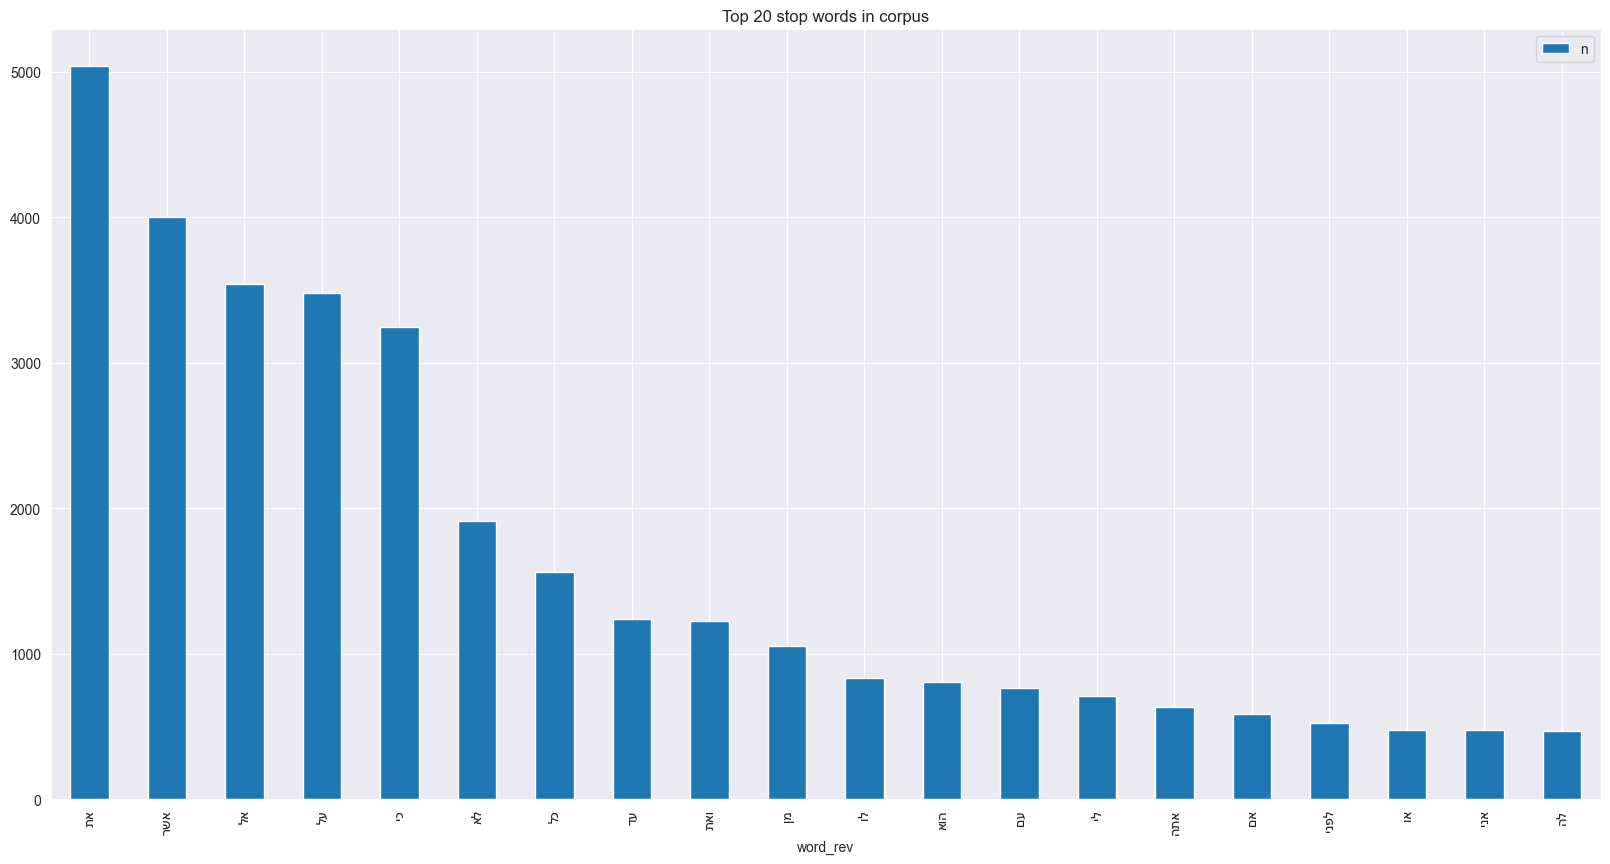

In [82]:
from collections import defaultdict
corpus=[]
words= df_by_book["text"].str.split()
words=words.values.tolist()
corpus=[word for i in words for word in i]


dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1
stop_words_dist = pd.DataFrame([dic]).T.reset_index().rename(columns={0:"n", "index":"word"})
stop_words_dist["word_rev"] =stop_words_dist["word"].str[::-1]
stop_words_dist = stop_words_dist.set_index("word_rev")
stop_words_dist.sort_values(by="n", ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 stop words in corpus")

<Axes: >

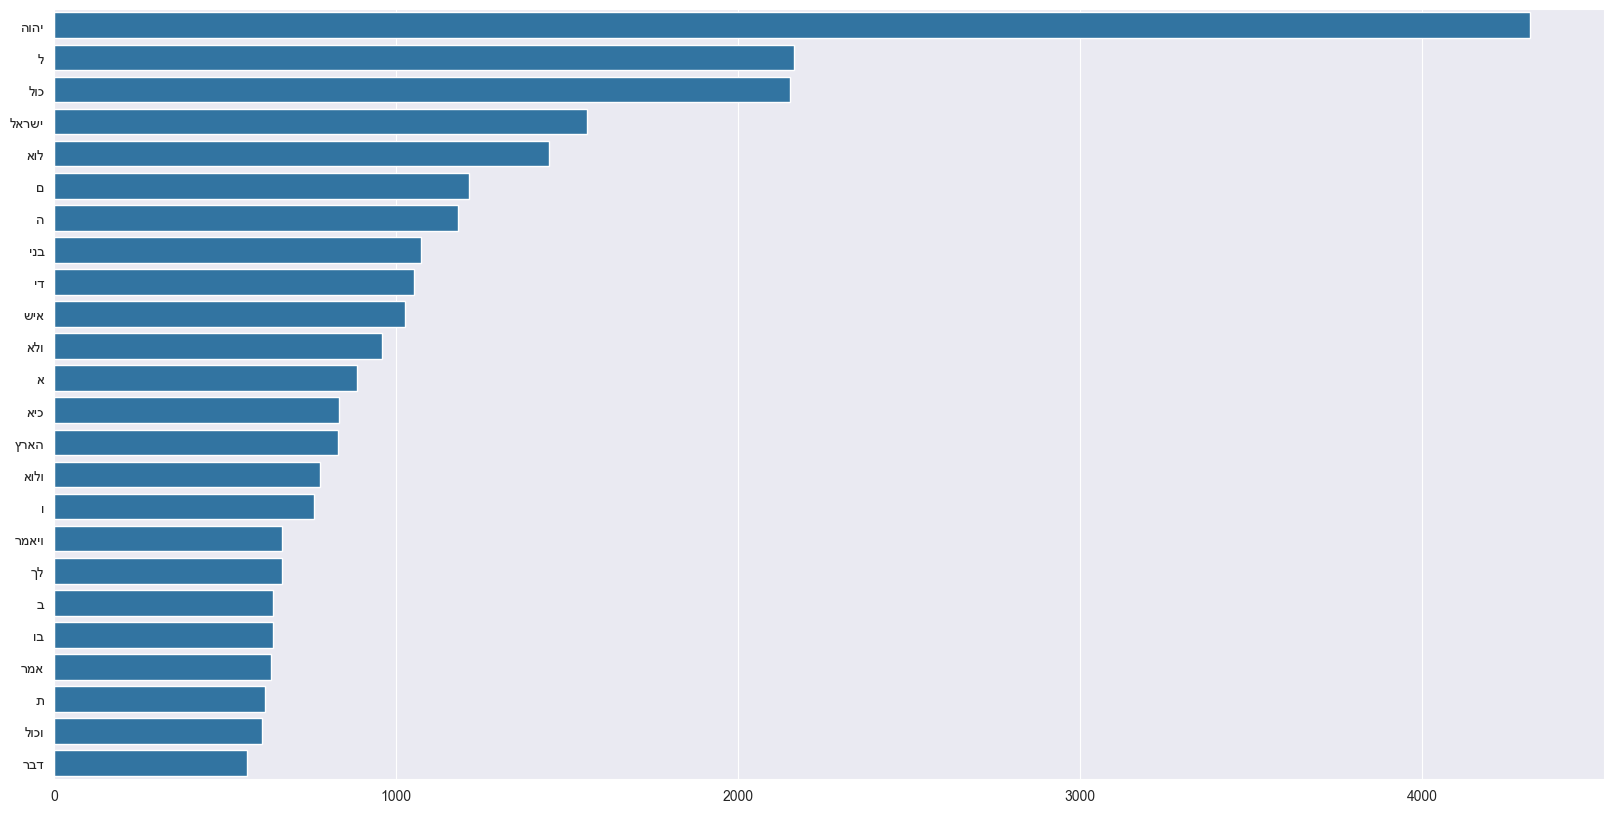

In [108]:
from collections import Counter
corpus=[]
words= df_by_book["processed_text"].str.split()
words=words.values.tolist()
corpus=[word for i in words for word in i]
corpus_no_punc = [word for word in corpus if word != "."]
counter=Counter(corpus_no_punc)
most=counter.most_common()

import seaborn as sns
x, y= [], []
for word,count in most[:40]:
    if (word not in stop_words):
        x.append(word[::-1])
        y.append(count)

sns.barplot(x=y,y=x)

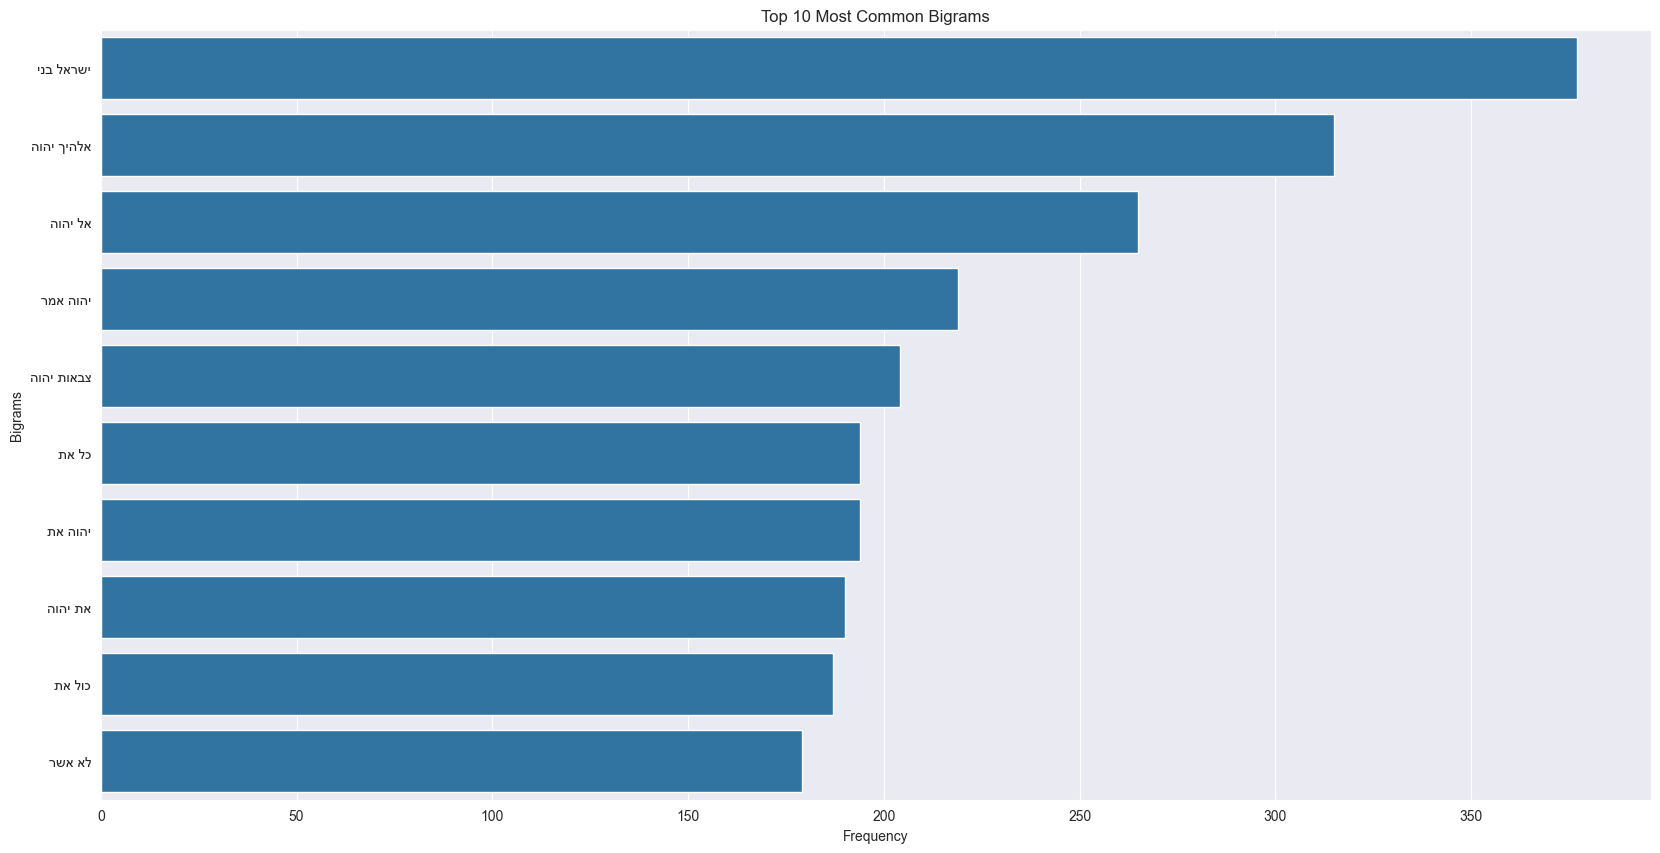

In [119]:
import nltk
from nltk.util import ngrams
from collections import Counter

def most_common_ngram(words, n=2):
    # Tokenize the corpus into words
    
    # Generate n-grams
    n_grams = ngrams(words, n)
    
    # Count and find the most common n-gram
    ngram_freq = Counter(n_grams)
    most_common = ngram_freq.most_common()  # Returns the most common n-gram and its frequency
    return most_common


corpus_no_punc_rev = [word[::-1] for word in corpus if word != "."]
def plot_ngram(words, k,n):
    top_n_bigrams=most_common_ngram(words,k)[:n]
    bigrams, counts = map(list, zip(*top_n_bigrams))
    bigrams = [' '.join(bigram) for bigram in bigrams]  # Convert tuple to string for better readability on plot
    
    sns.barplot(x=counts, y=bigrams)
    plt.xlabel('Frequency')
    plt.ylabel('Bigrams')
    plt.title('Top 10 Most Common Bigrams')
    plt.show()
plot_ngram(corpus_no_punc_rev,2, 10)


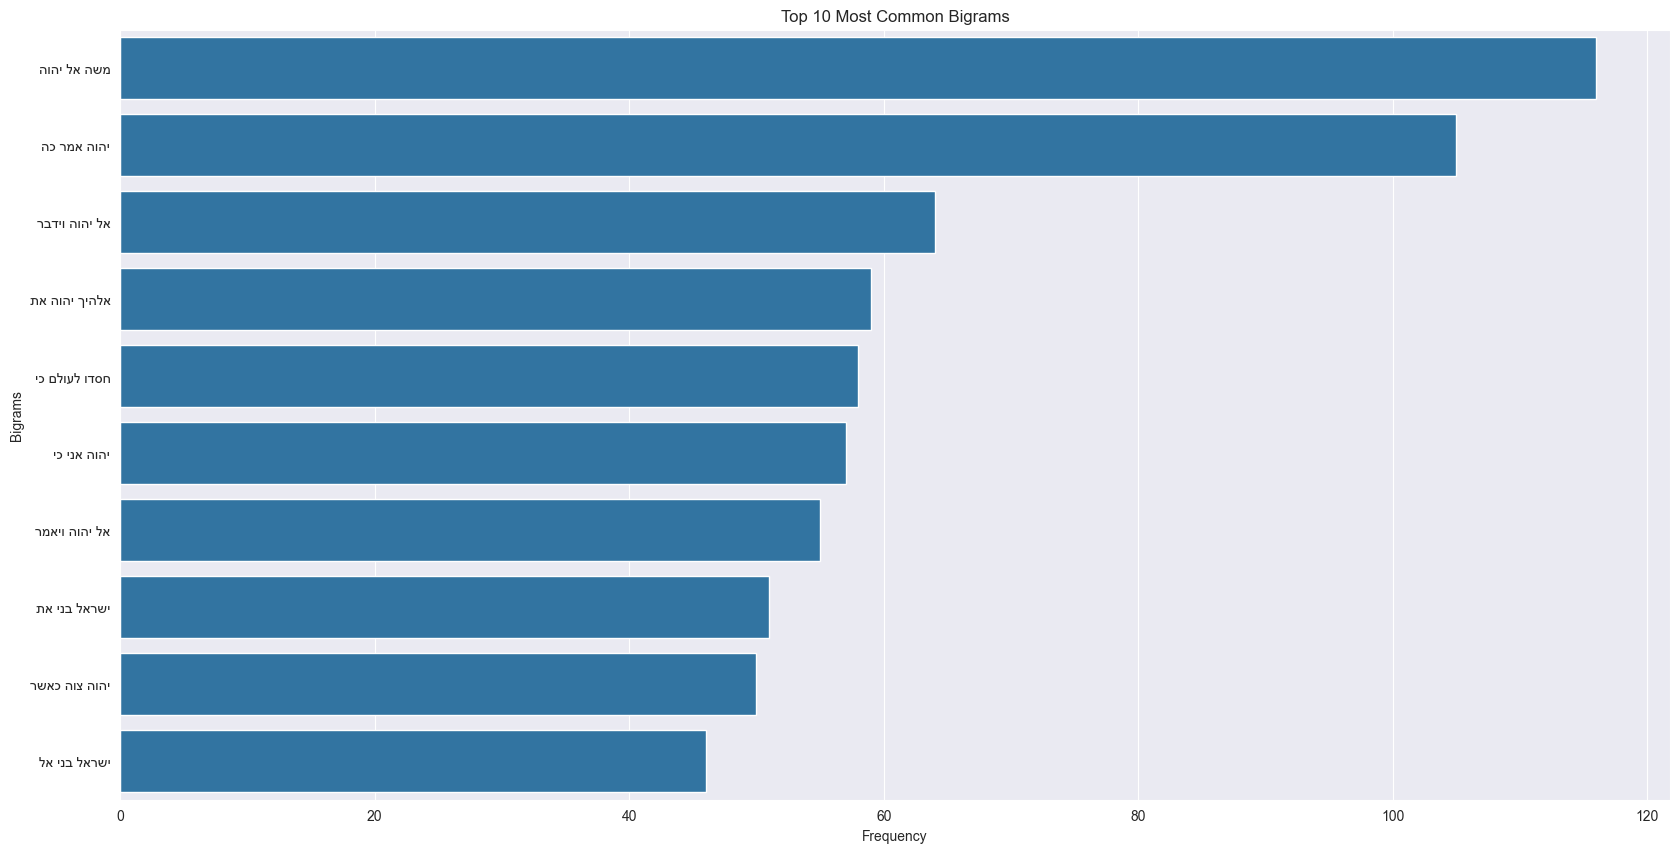

In [120]:
plot_ngram(corpus_no_punc_rev, 3,10)

In [30]:


def convert_doc_to_fixed_size_sentence(doc, window_size = 15):
    words = doc.split(" ")  # Split document into words based on spaces
    chunks = []
    current_chunk = []
    
    # Iterate through each word and build chunks of approximately 15 words
    word_count = 0
    for i, word in enumerate(words):
        current_chunk.append(word)
        word_count += 1
        if word_count == window_size or i == len(words)-1:
            chunks.append(' '.join(current_chunk))
            current_chunk = []
            word_count = 0
    return chunks

all_docs_resize = [convert_doc_to_fixed_size_sentence(doc, window_size=15) for doc in all_docs]